# Optional 2 - Physics: 
---
- How many particles to obtain stable results?
- Testing area preservation of the transport matrices
- Converging beam through a drift
---

##### First, Let's import standard packages and settings...

In [1]:
# Import custom tracking functions and useful libraries
from tracking_library import *

# Set up plotting
params = {
    "legend.fontsize": "x-large",
    "figure.figsize": (15, 5),
    "axes.labelsize": "x-large",
    "axes.titlesize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
}
plt.rcParams.update(params)

### Exercise 2.1Ph

Explore the dependence of the statistical error with on the beam divergence by a numerical simulation:
- Generate $N$ particle coordinates, for varying $N$ (e.g. [10, 100, 1000, 10000, ...]), with some offset/divergence spread 
   (e.g.  $<x> = 0.2$, $<x'> = 1$, $\sigma_{x} = 1.5$, $\sigma_{x'} = 0.5$)
- Compute the particle distribution angular divergence for each $N$
- Show, e.g. visually with a plot, that only for high $N$ one obtains a divergence which is "close" to the input 

**Hint:** Remember that you can create a Normal distributed 2xN 2D array of numbers as `np.random.randn(2, N)`. One can then "stretch" and "offset" (and eventually "rotate", but this is not requested here) this distribution to obtain any desired 2D normal distribution in phase space.

Text(0, 0.5, 'Beam divergence of the ensemble')

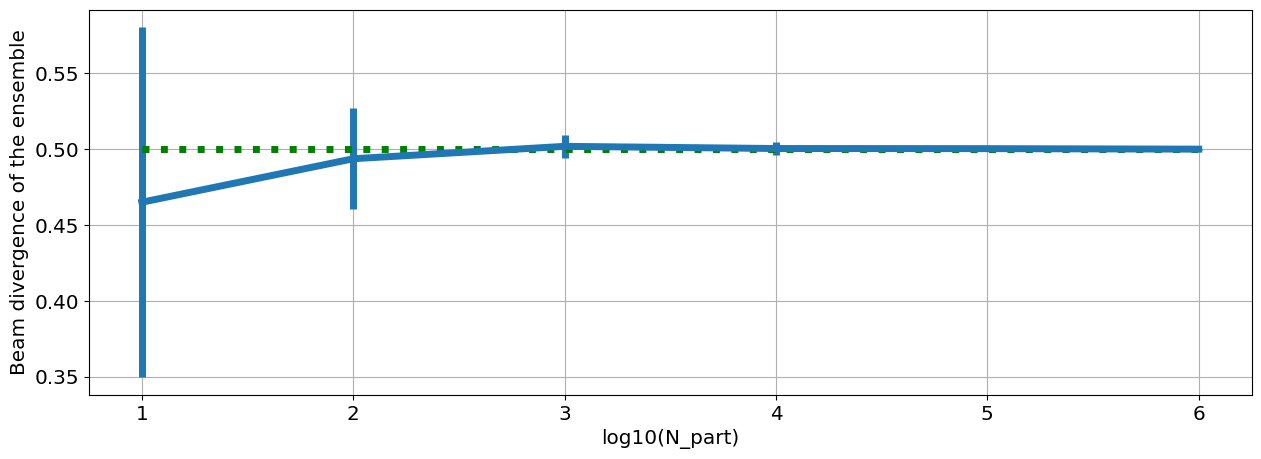

In [2]:
# Input values
x0 = 0.2
xp0 = 1
sigx = 1.5
sigxp = 0.5

# Let's collect mean diverge of particle distribution in lists
divergence = []
divergence_statistical_error = []
# generate number of particles array in some way...
npart_range = np.round(np.logspace(1, 6, num=6)).astype(int)

for Npart in npart_range:
    aux = []
    for j in range(10):
        beam = np.random.randn(2, Npart)
        beam[0, :] = sigx * beam[0, :] + x0
        beam[1, :] = sigxp * beam[1, :] + xp0
        aux.append(np.std(beam[1, :]))
    divergence.append(np.mean(aux))
    divergence_statistical_error.append(np.std(aux))
plt.errorbar(np.log10(npart_range), divergence, divergence_statistical_error, lw=5)
plt.plot([1, 6], [sigxp, sigxp], ":g", lw=5)
plt.grid(True)
plt.xlabel("log10(N_part)")
plt.ylabel("Beam divergence of the ensemble")

> **Depending on the required precision we need to select a convenient number of particles to model our beams!**

### Exercise 2.2Ph

Consider any simple beamline (e.g. a drift + quadrupole + drift).

- Consider 3 random particles in phase space such that they define a triangle of surface A. Verify that this linear transport preserve the area of the triangle.

    **IMPORTANT**: the area preservation is a condition stronger than the linearity. It is possible only for special matrices, the so-called symplectic matrices.
    A $2\times2$ matrix is symplectic if and only if its determinant is one.

    **Hint 1:** the area of a triangle in phase space can be computed using linear algebra:
    ```
    from numpy.linalg import norm
    def area(a, b, c) :
        '''a,b,c are the phase-space coordinates of three particles'''
        return 0.5 * norm( np.cross( b-a, c-a ) )
    ```

#### SOLUTION

In [3]:
# this is the formula of the area of a triangle
from numpy.linalg import norm


def area(a, b, c):
    """a,b,c are the phase-space coordinates of three particles"""
    return 0.5 * norm(np.cross(b - a, c - a))

In [4]:
# create simple beamline
beamline = D(1) + Q(1) + D(1)

# create particle coordinates
initial_coordinates = np.array([[1, 2, 3], [-1, 0, 2]])

# track them along the beamline
tracked = transportParticles(initial_coordinates, beamline)
final_coordinates = tracked["coords"][-1]

# code here your solution...
# we take the first three particles in the beam (arbitrary choise)
print(f"Before transport {area(initial_coordinates[:,0],initial_coordinates[:,1],initial_coordinates[:,2])}")
print(f"After transport {area(final_coordinates[:,0],final_coordinates[:,1],final_coordinates[:,2])}")

Before transport 0.5
After transport 0.5


/var/folders/6m/1nl4293j1rvdzdp_8pn3bjcw0000gn/T/ipykernel_73651/332859669.py:7: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return 0.5 * norm(np.cross(b - a, c - a))


We can visualise this in a plot:

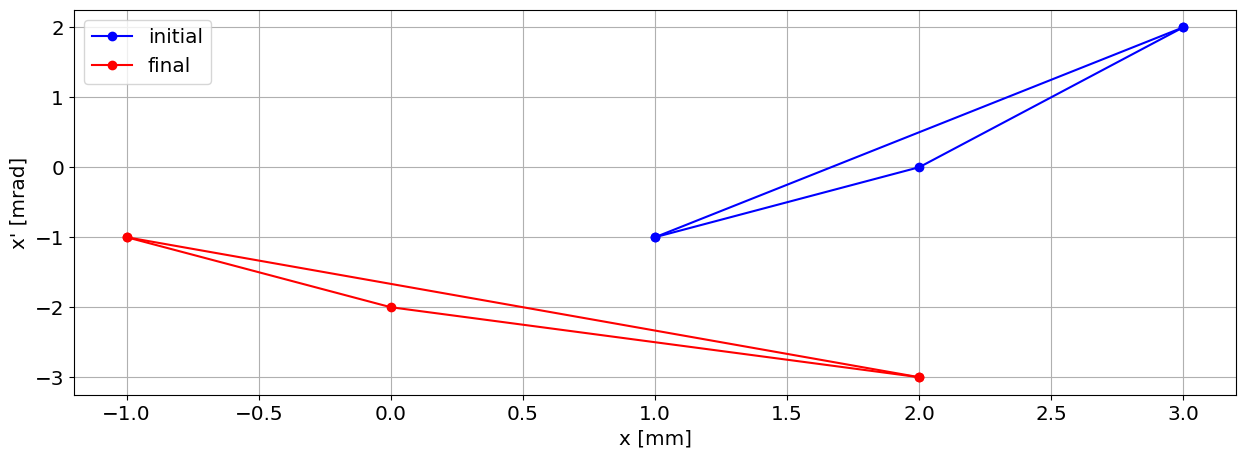

In [5]:
# first triangle
plt.plot(initial_coordinates[:, :3][0], initial_coordinates[:, :3][1], "o-b")
plt.plot(initial_coordinates[:, [2, 0]][0], initial_coordinates[:, [2, 0]][1], "o-b", label="initial")

# second triangle
plt.plot(final_coordinates[:, :3][0], final_coordinates[:, :3][1], "o-r")
plt.plot(final_coordinates[:, [2, 0]][0], final_coordinates[:, [2, 0]][1], "o-r", label="final")

plt.legend()
plt.xlabel("x [mm]")
plt.ylabel("x' [mrad]")
plt.grid(True)

### Exercise 2.3Ph

Consider a simple 10 m long drift, split in many short drifts (say 0.1 m-long each). Create an ensamble of 10000 particles matched to the following Twiss parameters: $(\beta = 10; \alpha=-0.1; \epsilon=1)$ using the function `beam` element from `tracking_library_advanced.py`.

1. Track the particles along the beamline using `transportParticles()` function
2. Track the Sigma matrix build from the input parameter using `transportSigmas()` function
3. Plot the sigma along s, and verify that 

**Note:** Can you explain why one obtains a non-linear behavior of the beam size?


#### SOLUTION

In [6]:
# Let's look at at the `beam()` function from `tracking_library_advanced`
from tracking_library_advanced import beam

help(beam)

Help on function beam in module tracking_library_advanced:

beam(emittance, beta, alpha, n_particles=100)
    Returns the x,x' coordinates of Gaussian beam matched to
    the given Twiss parameters (beta, gamma, emittance)



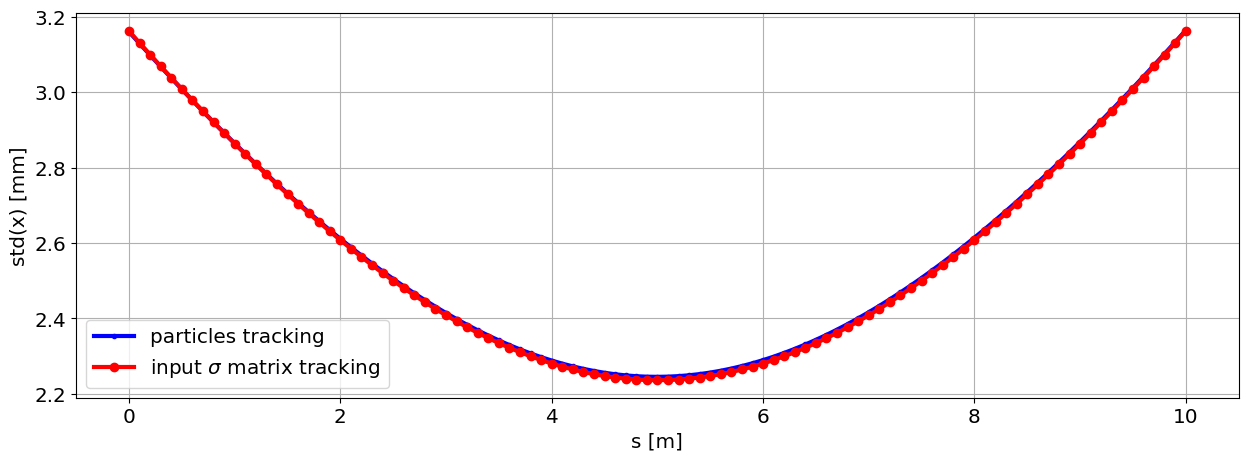

In [7]:
# create simple beamline
beamline = 100 * D(0.1)

# input parameters
beta = 10
alpha = 1
epsilon = 1

# create particle coordinates and sigma matrix
initial_coordinates = beam(epsilon, beta, alpha, 10000)
initial_sigma = epsilon * np.array([[beta, -alpha], [-alpha, (1 + alpha**2) / beta]])
# If you want to check with the "real" covariance matrix of the input distribution:
# initial_sigma = np.cov(initial_coordinates, bias=True)

# track them along the beamline
tracked_coordinates = transportParticles(initial_coordinates, beamline)
tracked_sigma = transportSigmas(initial_sigma, beamline)

# plot all estimation of beam size:
plt.plot(tracked_coordinates["s"], np.std(tracked_coordinates["x"], 1), ".-b", lw=3, label=r"particles tracking")
plt.plot(tracked_sigma["s"], np.sqrt(tracked_sigma["sigma11"]), "o-r", lw=3, label=r"input $\sigma$ matrix tracking")
plt.grid(True)
plt.xlabel("s [m]")
plt.ylabel("std(x) [mm]")
plt.legend()

> **We obtained a beam waist!**